# GEMS Crop Calendar Example Usage
Below is a simple example that illustrates how to access crop calendar raster data in the GEMS Crop API.
### Set up an HTTP client using Python's request library
We use a `Session` object to store our API key and automatically include it in the header for each request.

Note that we have a `api_key.py` file in the same directory as this notebook. The file contains only the below line.
```
key = 'SECRET'
```

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 500
import json
import rasterio
from matplotlib import pyplot as plt
from requests import Session
import numpy as np
import sys
sys.path.append('..')
from api_key import key

s = Session()
s.headers.update({'apikey': key})

api_url = 'https://exchange-1.gems.msi.umn.edu/crop/v2'

### Select dataset of interest

In [2]:
res = s.get(f'{api_url}/datasets')
datasets = pd.json_normalize(res.json())
dataset_key = datasets.loc[0]['keyname']
display(datasets)

,name,description,id,keyname,app_name
0,Sacks Crop Calendar,"This dataset is the result of digitizing and georeferencing existing observations of crop planting and harvesting dates. Sacks, W.J., D. Deryng, J.A. Foley, and N. Ramankutty (2010)",29,sacks-calendar,crop


### Get available layers for dataset
Listing all available layers for our datset of interest

In [3]:
res = s.get(f'{api_url}/{dataset_key}/layer')
layer_df = pd.json_normalize(res.json())
display(layer_df)

,name,units,description,discrete,id
0,Wheat-plant-end,days,Wheat-plant-end,False,364
1,Yams-plant-end,days,Yams-plant-end,False,365
2,Barley-Winter-plant,days,Barley-Winter-plant,False,366
3,Barley-plant,days,Barley-plant,False,367
4,Barley-Winter-plant-start,days,Barley-Winter-plant-start,False,316
...,...,...,...,...,...
220,Sunflower-total-days,days,Sunflower-total-days,False,536
221,Sweet-Potatoes-total-days,days,Sweet-Potatoes-total-days,False,537
222,Wheat-Winter-total-days,days,Wheat-Winter-total-days,False,538
223,Wheat-total-days,days,Wheat-total-days,False,539


### Selecting layers of interest
We use the code below to list layers for different crops and create a list of their dataframe indices. In this example, we are interested in maize and barley harvest/planting dates.

In [4]:
crop_of_interest = 'barley'
layer_df.loc[layer_df['name'].str.lower().str.contains(crop_of_interest)]

,name,units,description,discrete,id
2,Barley-Winter-plant,days,Barley-Winter-plant,False,366
3,Barley-plant,days,Barley-plant,False,367
4,Barley-Winter-plant-start,days,Barley-Winter-plant-start,False,316
5,Barley-plant-start,days,Barley-plant-start,False,317
29,Barley-Winter-plant-end,days,Barley-Winter-plant-end,False,341
30,Barley-plant-end,days,Barley-plant-end,False,342
75,Barley-Winter-plant-range,days,Barley-Winter-plant-range,False,391
76,Barley-plant-range,days,Barley-plant-range,False,392
100,Barley-Winter-harvest-start,days,Barley-Winter-harvest-start,False,416
101,Barley-harvest-start,days,Barley-harvest-start,False,417


In [5]:
ids_of_interest = [56, 156, 3, 151] # maize/barley plant/harvest date indices in the above dataframe
data_of_interest = layer_df.loc[ids_of_interest]
data_of_interest

,name,units,description,discrete,id
56,Maize-plant,days,Maize-plant,False,372
156,Maize-harvest,days,Maize-harvest,False,472
3,Barley-plant,days,Barley-plant,False,367
151,Barley-harvest,days,Barley-harvest,False,467


### Get objects of interest
We use the layer IDs obtained above to obtain object IDs and add them as a new column to the DataFrame.

In [6]:
for index, row in data_of_interest.iterrows():
    res = s.get(f'{api_url}/{dataset_key}/object/search', params={'layer': row.id})
    data_of_interest.at[index, 'obj_id'] = str(res.json()[0]['id'])

data_of_interest

,name,units,description,discrete,id,obj_id
56,Maize-plant,days,Maize-plant,False,372,187614
156,Maize-harvest,days,Maize-harvest,False,472,187714
3,Barley-plant,days,Barley-plant,False,367,187609
151,Barley-harvest,days,Barley-harvest,False,467,187709


### Access Sacks calendar data for crop of interest
#### Point
We use the `/object/{object_id}/point` endpoint to obtain values for each object_id (obtained above) of interest and add them to the DataFrame for a point of interest.

In [7]:
lat = 45.9592
lon = -93.6146

for index, row in data_of_interest.iterrows():
    res = s.get(f'{api_url}/{dataset_key}/object/{row.obj_id}/point', params={'lat': lat, 'lon': lon})
    data = res.json()
    data_of_interest.at[index, 'val'] = data['value']

data_of_interest

,name,units,description,discrete,id,obj_id,val
56,Maize-plant,days,Maize-plant,False,372,187614,136.5
156,Maize-harvest,days,Maize-harvest,False,472,187714,302.0
3,Barley-plant,days,Barley-plant,False,367,187609,131.0
151,Barley-harvest,days,Barley-harvest,False,467,187709,237.0


#### Polygon
To obtain a raster for an area of interest in 2020 we use a POST request with the `/object/{object_id}/raster` endpoint. Below we use the object IDs obtained above to obtain and plot barley/maize plant/harvest dates for Minnesota and parts of neighboring states.

Maize-plant


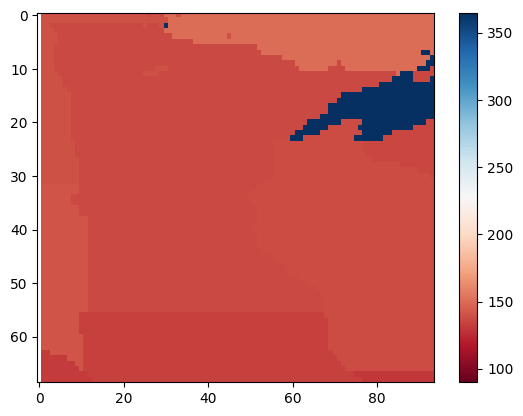

Maize-harvest


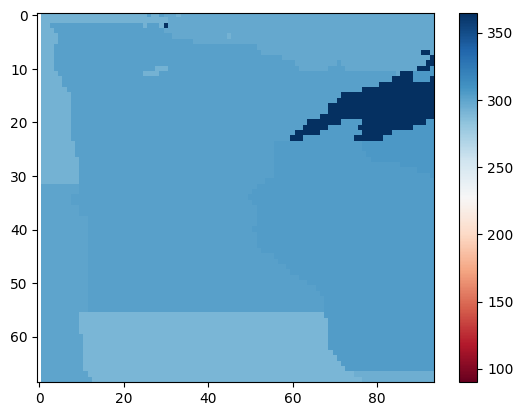

Barley-plant


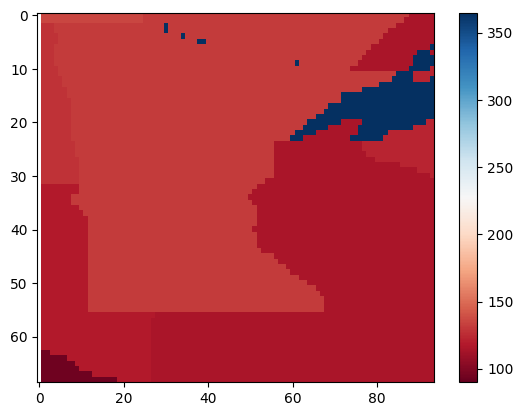

Barley-harvest


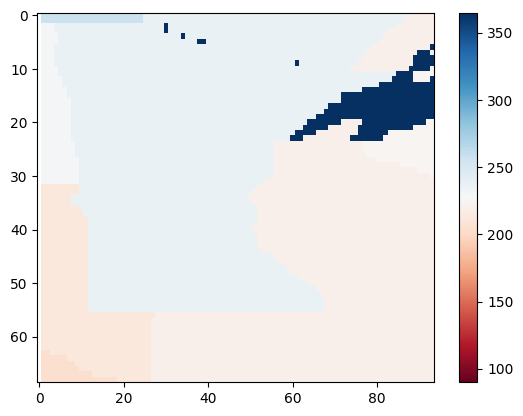

In [8]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [
                -97.5146484375,
                42.3016903282445
            ],
            [
                -88.824462890625,
                42.3016903282445
            ],
            [
                -88.824462890625,
                49.196064000723794
            ],
            [
                -97.5146484375,
                49.196064000723794
            ],
            [
                -97.5146484375,
                42.3016903282445
            ]
        ]
    ]
}

for index, row in data_of_interest.iterrows():
    res = s.post(f'{api_url}/{dataset_key}/object/{row.obj_id}/raster', json=area_of_interest)
    raster =  res.content
    with rasterio.MemoryFile(raster) as memfile:
        with memfile.open() as dataset:
                print(row['name'])
                data = dataset.read(1)
                data[data == dataset.nodatavals[0]] = np.nan
                img = plt.imshow(data, cmap='RdBu', aspect='auto', vmin=90, vmax=365)
                plt.colorbar(img)
                plt.show()